In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Session data

In [4]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [5]:
session = sessions[0]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009265_hippoSIT_2023-02-24_09-53-26'

### Choose target selective units

In [6]:
offset    = 7.25
bin_count = 30

In [7]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

14 units selected


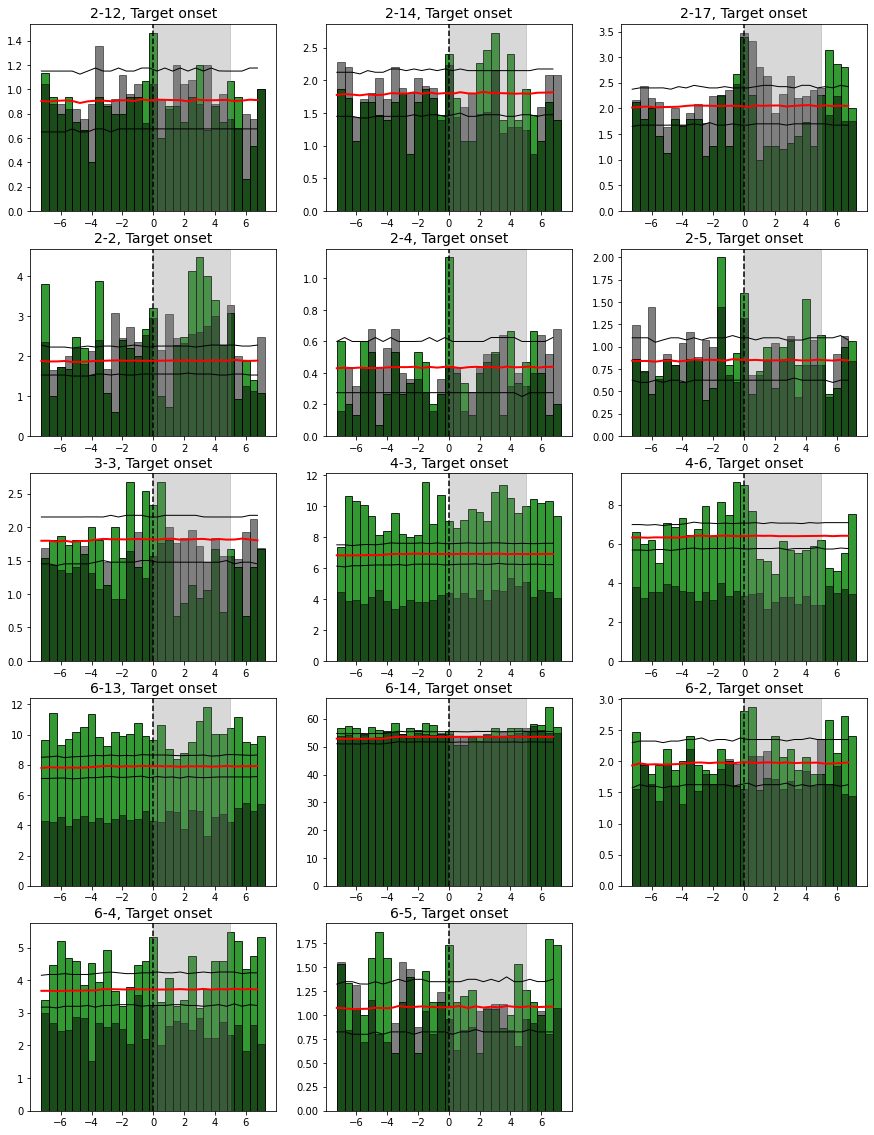

In [8]:
selected    = tgt_units
tgt_dur     = cfg['experiment']['target_duration']

event_times = tl[tgt_matrix[:, 0]][:, 0]
idxs_succ   = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss   = np.where(tgt_matrix[:, 4] == 0)[0]

cols = 3
rows = int(np.ceil(len(selected)/cols))
fig = plt.figure(figsize=(15, rows*4))

zero_bin_stats = np.zeros((len(selected), 3))
for i, unit_name in enumerate(selected):
    strain = spike_times[unit_name]

    # compute original
    bins, enters_succ = get_spike_counts(strain, tl[tgt_matrix[idxs_succ][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    bins, enters_miss = get_spike_counts(strain, tl[tgt_matrix[idxs_miss][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    
    # get shuffled
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
        
   
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=enters_succ, edgecolor='black', color='green', alpha=0.8, label='high')
    ax.hist(bins[:-1], bins=bins, weights=enters_miss, edgecolor='black', color='black', alpha=0.5, label='high')
    ax.axvline(0, color='black', ls='--')
    ax.set_title("%s, Target onset" % unit_name, fontsize=14)
    ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 2], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')
    
fig.savefig(os.path.join(report_path, 'PSTH_tgt_onset_succ_miss_TGT_only.pdf'))

### Compute firing at onset statistics

In [9]:
selected    = list(tgt_units)
event_times = tl[tgt_matrix[:, 0]][:, 0]
idxs_succ   = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss   = np.where(tgt_matrix[:, 4] == 0)[0]

# shuffled mean, FR at miss, FR at success, brain area (0/1)
zero_bin_stats = np.zeros((len(selected), 4))
for j, unit_name in enumerate(selected):
    strain = spike_times[unit_name]

    bins, enter_low  = get_spike_counts(strain, tl[tgt_matrix[idxs_miss][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    bins, enter_high = get_spike_counts(strain, tl[tgt_matrix[idxs_succ][:, 0]][:, 0], hw=offset, bin_count=bin_count)

    # get shuffled
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])

    zero_bin_idx = len(bins[bins < 0]) - 1
    zero_bin_stats[j] = np.array([
        shuffled[zero_bin_idx][1], 
        enter_low[zero_bin_idx], 
        enter_high[zero_bin_idx],
        0 if int(unit_name[0]) < 3 else 1
    ])

Text(0, 0.5, 'Unit #')

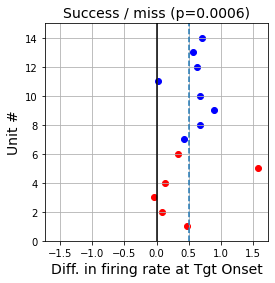

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

deltas = (zero_bin_stats[:, 2] - zero_bin_stats[:, 1])/zero_bin_stats[:, 0]
unit_count = len(deltas)
d_max = np.abs(deltas).max()

unit_numbers = np.arange(unit_count) + 1
for i, color in enumerate(['red', 'blue']):  # diff brain areas
    idxs = np.where(zero_bin_stats[:, 3] == i)[0]
    ax.scatter(deltas[idxs], unit_numbers[idxs], color=color, label=areas[i])

ax.set_ylim(0, unit_count + 1)
ax.set_xlim(-1.1*d_max, 1.1*d_max)
ax.axvline(0, color='black')
ax.axvline(deltas.mean(), ls='--')
ax.grid()
ax.set_title('Success / miss (p=%.4f)' % stats.ttest_1samp(deltas, 0)[1], fontsize=14)
ax.set_xlabel('Diff. in firing rate at Tgt Onset', fontsize=14)
ax.set_ylabel('Unit #', fontsize=14)